In [1]:
# Setup, imports
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import statistics
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from patsy import dmatrices
import statsmodels.api as sm 
import scipy.stats as stats
from tableone import TableOne
from statistics import mean
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif
from numpy import inf


#import graphviz
#from graphviz import Source
from IPython.display import SVG

from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn import preprocessing, decomposition
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.metrics import auc 
from sklearn.metrics import RocCurveDisplay


matplotlib.rcParams['figure.figsize'] = [5, 3]
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

C:\Users\rckyh\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rckyh\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\rckyh\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [45]:
#imporitng and cleaning data
allClinData = pd.read_excel('clinical_data.xlsx')
#changing "YES" = 1 and "NO" = 0 and "F" = 0 and "M" = 1
allClinData.replace(('YES','NO'),(1,0), inplace=True)
allClinData.loc[(allClinData.Sex == 'M'), 'Sex'] = 1
allClinData.loc[(allClinData.Sex == 'F'), 'Sex'] = 0
outcomeColName = 'Death/ACS/Stroke/TIA/CEA/CABG/PCI/CHF censor'
outcomeCols = [outcomeColName]
idCol = ['Study ID #']

#waist circumference is not very filled, removing it for now
clinHistCols = ['Age (yrs) at time of study', 'Sex', 'Creatinine (µmol/L)',
               'BMI (kg/m2)', 
                #'Waist circum. (cm)', 
                'History of MI  (Y/N)', 
                'Diabetes (Y/N)', 'Tobacco use (Y/N)', 
                'History of Hypertension (Y/N)','Hyperlipidemia (Y/N)',
                'Family history of Cardiac Disease (Y/N)',
                'Known CAD (CABG/PCI/MI)']

drugsCols = ['ASA', 'Beta Blocker', 'ACE Inhibitor', 'ARB',
             'Calcium Channel Blocker', 'Statins']

#ath extent, rt plq vol, lt plq vol, tot plq vol are empty so I excluded those
imagingCols = [ #'Extent of atherosclerotic burden (# of vessels)',
              'Rt CCA Distal far wall mean IMT (mm)',
              'Lt CCA Distal far wall mean IMT (mm)',
              'Mean CIMT, CCA far distal (mm)',
              'Rt Max Plaque Height (mm)',
              'Lt Max Plaque Height (mm)',
              'Max Plaque Height (PH), Rt or Lt Bulbs (mm)',
              'Max PH ≥1.5 mm', 'Rt Area (mm2)', 'Lt Area (mm2)',
              'Total Plaque Area (TPA), Rt + Lt Bulbs (mm2)',
              #'Rt Plaque Volume (mL)', 'Lt Plaque Volume (mL)',
              #'Total Plaque Volume (TPV), Rt + Lt Bulbs (mL)',
              'Right GSM (all sections)',
              'RT % blood (0-4)', 'RT % fat (8-26)','RT % muscle (41-76)',
              'RT % fibrous tissue (112-196)', 'RT % calcium (211-255)',
              'RT % undefined', 'RT % p40', 'Left GSM (all sections)',
              'LT % blood (0-4)', 'LT % fat (8-26)', 'LT % muscle (41-76)',
              'LT % fibrous tissue (112-196)', 'LT % calcium (211-255)',
              'LT % undefined','LT p40','Mean GSM (Rt & Lt)',
              'adjusted mean % blood (0-4)','adjusted fat (8-26)',
              'adjusted mean % muscle (41-76)',
              'adjusted mean % fibrous tissue (112-196)',
              'adjusted mean % calcium (211-255)',
              'adjusted mean % undefined','adjusted mean p40',
              'Mean Pixels <P40 (Rt & Lt)']

relevantColsOnly = allClinData[idCol + outcomeCols + clinHistCols + drugsCols + imagingCols]


#imputing 0s into NaN for imaging olumbs
relevantColsOnly[imagingCols] = relevantColsOnly[imagingCols].fillna(0)
#dropping patients with missing clinical data, note one row has "unknown"
relevantColsOnly = relevantColsOnly[~relevantColsOnly.isin(['UNKNOWN']).any(axis=1)]
relevantColsOnly = relevantColsOnly.dropna()

# we need the ID just for the join with radimoics data later
relevantColsOnlyWithID = relevantColsOnly.drop(columns = outcomeCols)
relevantColsOnly = relevantColsOnly.drop(columns = idCol)
relevantColsOnlyWithID

,Study ID #,Age (yrs) at time of study,Sex,Creatinine (µmol/L),BMI (kg/m2),History of MI (Y/N),Diabetes (Y/N),Tobacco use (Y/N),History of Hypertension (Y/N),Hyperlipidemia (Y/N),...,LT p40,Mean GSM (Rt & Lt),adjusted mean % blood (0-4),adjusted fat (8-26),adjusted mean % muscle (41-76),adjusted mean % fibrous tissue (112-196),adjusted mean % calcium (211-255),adjusted mean % undefined,adjusted mean p40,Mean Pixels <P40 (Rt & Lt)
3,7,65,0,59.0,29.1,0.0,0.0,0.0,0.0,1.0,...,44.435216,83.0,1.411960,9.883721,24.756388,30.948110,0.000000,32.999821,22.264076,22.27
5,9,75,1,132.0,25.1,1.0,0.0,0.0,1.0,1.0,...,27.568270,55.5,2.047693,16.293420,34.453209,11.561018,0.000000,35.644660,33.950024,33.94
6,11,75,1,148.0,27.6,1.0,0.0,0.0,0.0,1.0,...,0.000000,48.0,4.294756,20.433996,38.652803,5.605787,0.000000,31.012658,41.003617,40.87
7,13,68,0,77.0,26.3,0.0,0.0,0.0,1.0,1.0,...,61.005053,29.0,24.480629,19.118473,22.150477,2.863560,0.000000,31.386861,61.005053,61.01
8,14,49,0,59.0,20.0,0.0,0.0,1.0,1.0,1.0,...,39.081848,53.0,5.436424,18.151616,26.215645,10.540622,0.000000,39.655693,39.081848,39.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2011342,75,1,118.0,23.7,0.0,0.0,0.0,1.0,1.0,...,55.872624,31.5,13.373395,27.675036,20.789622,10.086873,1.922022,26.153052,56.508340,56.51
518,2011343,76,1,87.0,27.8,1.0,1.0,1.0,1.0,1.0,...,53.087963,42.5,1.303816,27.218704,27.438043,10.880976,2.293287,30.865174,48.019148,48.02
519,2011344,77,1,136.0,42.3,0.0,0.0,0.0,1.0,1.0,...,84.081799,26.5,9.078448,35.749718,19.567616,2.632374,0.099388,32.872456,72.927750,72.94
520,2011345,76,1,151.0,25.2,0.0,0.0,0.0,1.0,1.0,...,18.884930,59.0,1.397417,11.005488,38.072741,14.175023,3.284485,32.064847,27.958239,27.96


In [52]:
#importing and joining radiomics data
radiomicsDataAll = pd.read_csv('radiomics_input.csv')
radiomicsDataAll = radiomicsDataAll.drop(columns = ['imName'])
# have to join the clinical data that is available

joinedData = pd.merge(radiomicsDataAll, relevantColsOnlyWithID, on = 'Study ID #',
                    how = 'left')

# defining the different datasets
tempToGetRadiomicsCols = radiomicsDataAll.drop(columns = ['Death/ACS/Stroke/TIA/CEA/CABG/PCI/CHF censor',
                                                           'Study ID #'])
radiomicsCols = tempToGetRadiomicsCols.columns.tolist()

#creating different dtasets
#now we can separate to different datasets to train the classifier

#also dropping NAs from the joins wiht radiomics as some patients dont have imaging data 
clinHistOnly = relevantColsOnly[outcomeCols + clinHistCols]
drugsOnly = relevantColsOnly[outcomeCols + drugsCols]
# combining drugs and clinical hisotry as just "clinical history" after discussion
clinHistAndDrugs = relevantColsOnly[outcomeCols + clinHistCols + drugsCols]
imagingOnly = relevantColsOnly[outcomeCols + imagingCols]
clinHistAndImaging = relevantColsOnly[outcomeCols + clinHistCols 
                                      + drugsCols + imagingCols ]

radiomicsOnly = joinedData[outcomeCols + radiomicsCols].dropna()
radiomicsAndClinHist = joinedData[outcomeCols + radiomicsCols
                                   + clinHistCols + drugsCols].dropna()
radiomicsAndImaging = joinedData[outcomeCols + radiomicsCols + imagingCols].dropna()
allData = joinedData[outcomeCols + radiomicsCols
                    + clinHistCols + drugsCols + imagingCols].dropna()

#saving the dataframes
allData.to_csv('allData.csv', index = False)  
clinHistAndDrugs.to_csv('clinHistOnly.csv', index = False)  
clinHistAndImaging.to_csv('clinHistAndImaging.csv', index = False)  
imagingOnly.to_csv('imagingOnly.csv', index = False)  
radiomicsOnly.to_csv('radiomicsOnly.csv', index = False)  
radiomicsAndClinHist.to_csv('radiomicsAndClinHist.csv', index = False)  
radiomicsAndImaging.to_csv('radiomicsAndImaging.csv', index = False)  

In [67]:
#intial table1 stats for smoke test
columns = relevantColsOnly.columns.tolist()
tableOneStats = TableOne(relevantColsOnly, columns=columns, pval = True, htest_name=True, smd=True,
                         groupby = ['Death/ACS/Stroke/TIA/CEA/CABG/PCI/CHF censor'])
tableOneStats

Grouped by Death/ACS/Stroke/TIA/CEA/CABG/PCI/CHF censor                                                                                                        
                                                                                                            Missing               Overall                      0                     1 P-Value               Test SMD (0,1)
n                                                                                                                                     493                    349                   144                                     
Study ID #, mean (SD)                                                                                             0  1244338.0 (977714.1)  1083508.6 (1003877.4)  1634125.8 (787601.9)  <0.001  Two Sample T-test     0.610
Age (yrs) at time of study, mean (SD)                                                                             0           65.1 (10.5)            64.1 (10.5)           67.5 (10.3)   0.001  Two Sample T-test     0.332
Sex, n (%)                                              0                                                         0            161 (32.7)             125 (35.8)             36 (25.0)   0.026        Chi-squared     0.237
                                                        1                                                                      332 (67.3)             224 (64.2)            108 (75.0)                                     
Creatinine (µmol/L), mean (SD)                                                                                    0           90.4 (52.0)            86.6 (38.5)           99.7 (74.7)   0.047  Two Sample T-test     0.220
BMI (kg/m2), mean (SD)                                                                                            0            29.9 (6.3)             30.0 (6.3)            29.6 (6.5)   0.510  Two Sample T-test    -0.066
History of MI  (Y/N), n (%)                             0.0                                                       0            379 (76.9)             274 (78.5)            105 (72.9)   0.222        Chi-squared     0.131
                                                        1.0                                                                    114 (23.1)              75 (21.5)             39 (27.1)                                     
Diabetes (Y/N), n (%)                                   0.0                                                       0            350 (71.0)             253 (72.5)             97 (67.4)   0.302        Chi-squared     0.112
                                                        1.0                                                                    143 (29.0)              96 (27.5)             47 (32.6)                                     
Tobacco use (Y/N), n (%)                                0.0                                                       0            407 (82.6)             292 (83.7)            115 (79.9)   0.378        Chi-squared     0.099
                                                        1.0                                                                     86 (17.4)              57 (16.3)             29 (20.1)                                     
History of Hypertension (Y/N), n (%)                    0.0                                                       0            139 (28.2)             103 (29.5)             36 (25.0)   0.367        Chi-squared     0.101
                                                        1.0                                                                    354 (71.8)             246 (70.5)            108 (75.0)                                     
Hyperlipidemia (Y/N), n (%)                             0.0                                                       0            102 (20.7)              80 (22.9)             22 (15.3)   0.075        Chi-squared     0.195
                                                        1.0                                         

Correlation Heatmap for Clinical Data


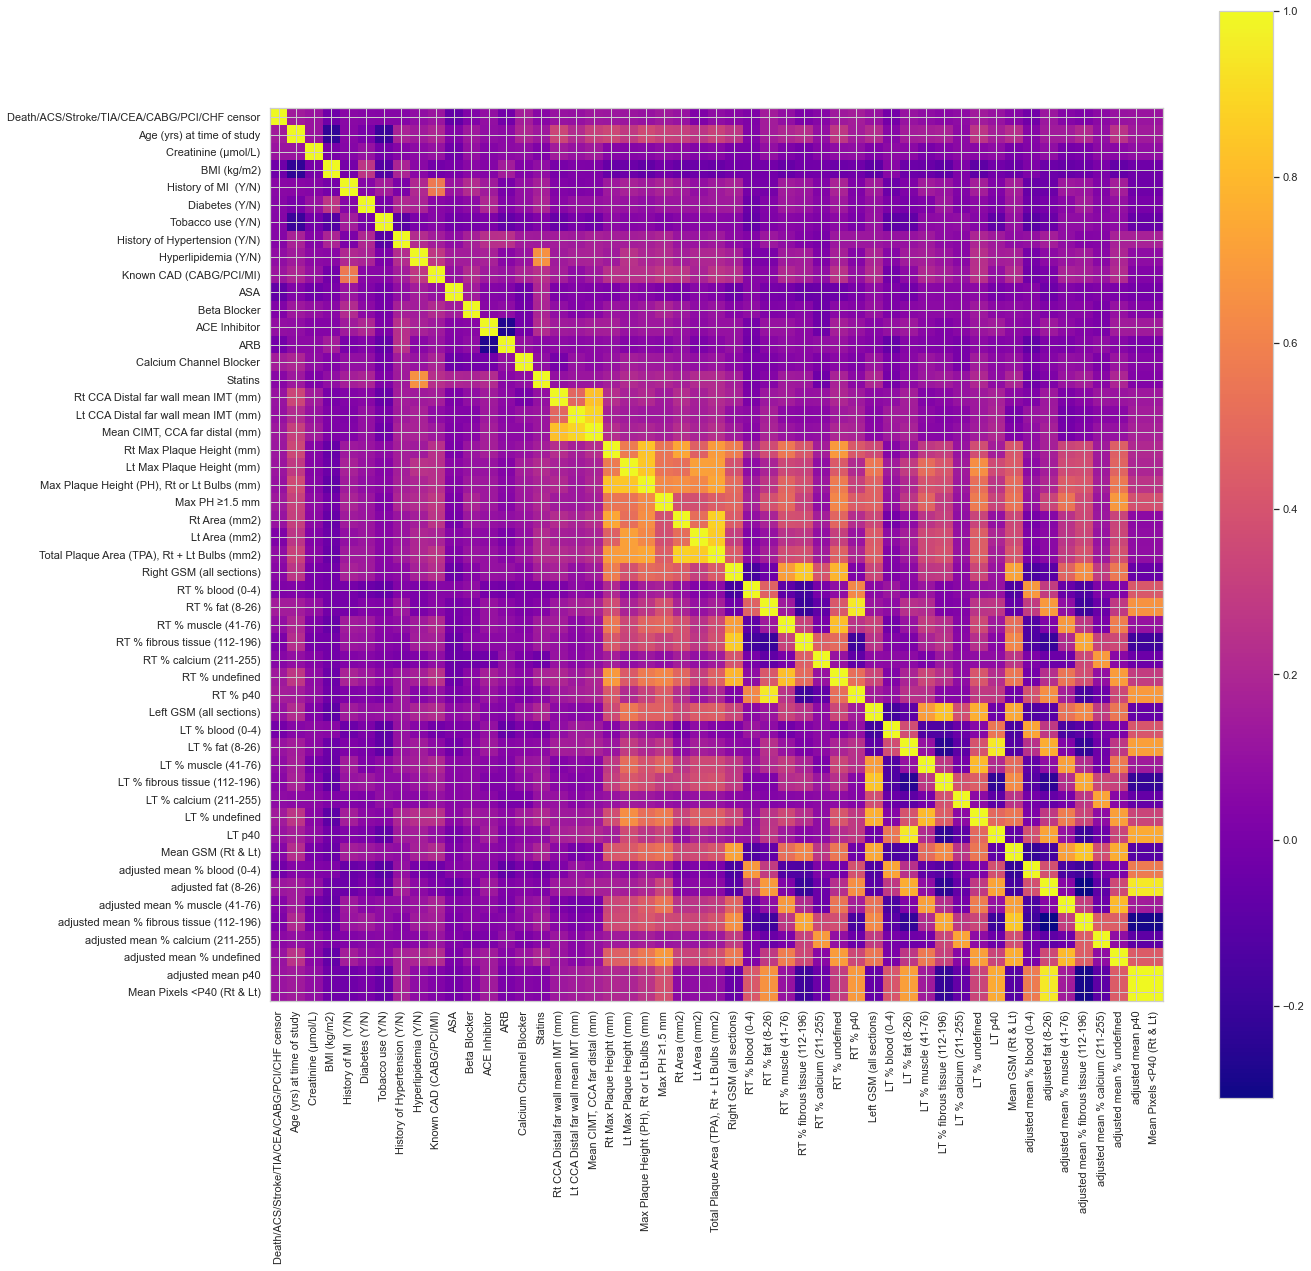

In [58]:
#first order correlation ratios between variables
corrMatrixClinData = relevantColsOnly.corr()
print('Correlation Heatmap for Clinical Data')
fig, ax = plt.subplots(figsize=[20,20])
im = ax.imshow(corrMatrixClinData, cmap='plasma')
ax.set_xticks(np.arange(len(corr_matrix)))
ax.set_yticks(np.arange(len(corr_matrix)))
ax.set_xticklabels(corrMatrixClinData.columns)
ax.set_yticklabels(corrMatrixClinData.columns)
plt.xticks(rotation='vertical')
plt.colorbar(im)
plt.savefig('corrMatrixClinData.png')
corrMatrixClinData.to_csv('corrMatrixClinData.csv', index = False)


Correlation Heatmap for Radiomics Data


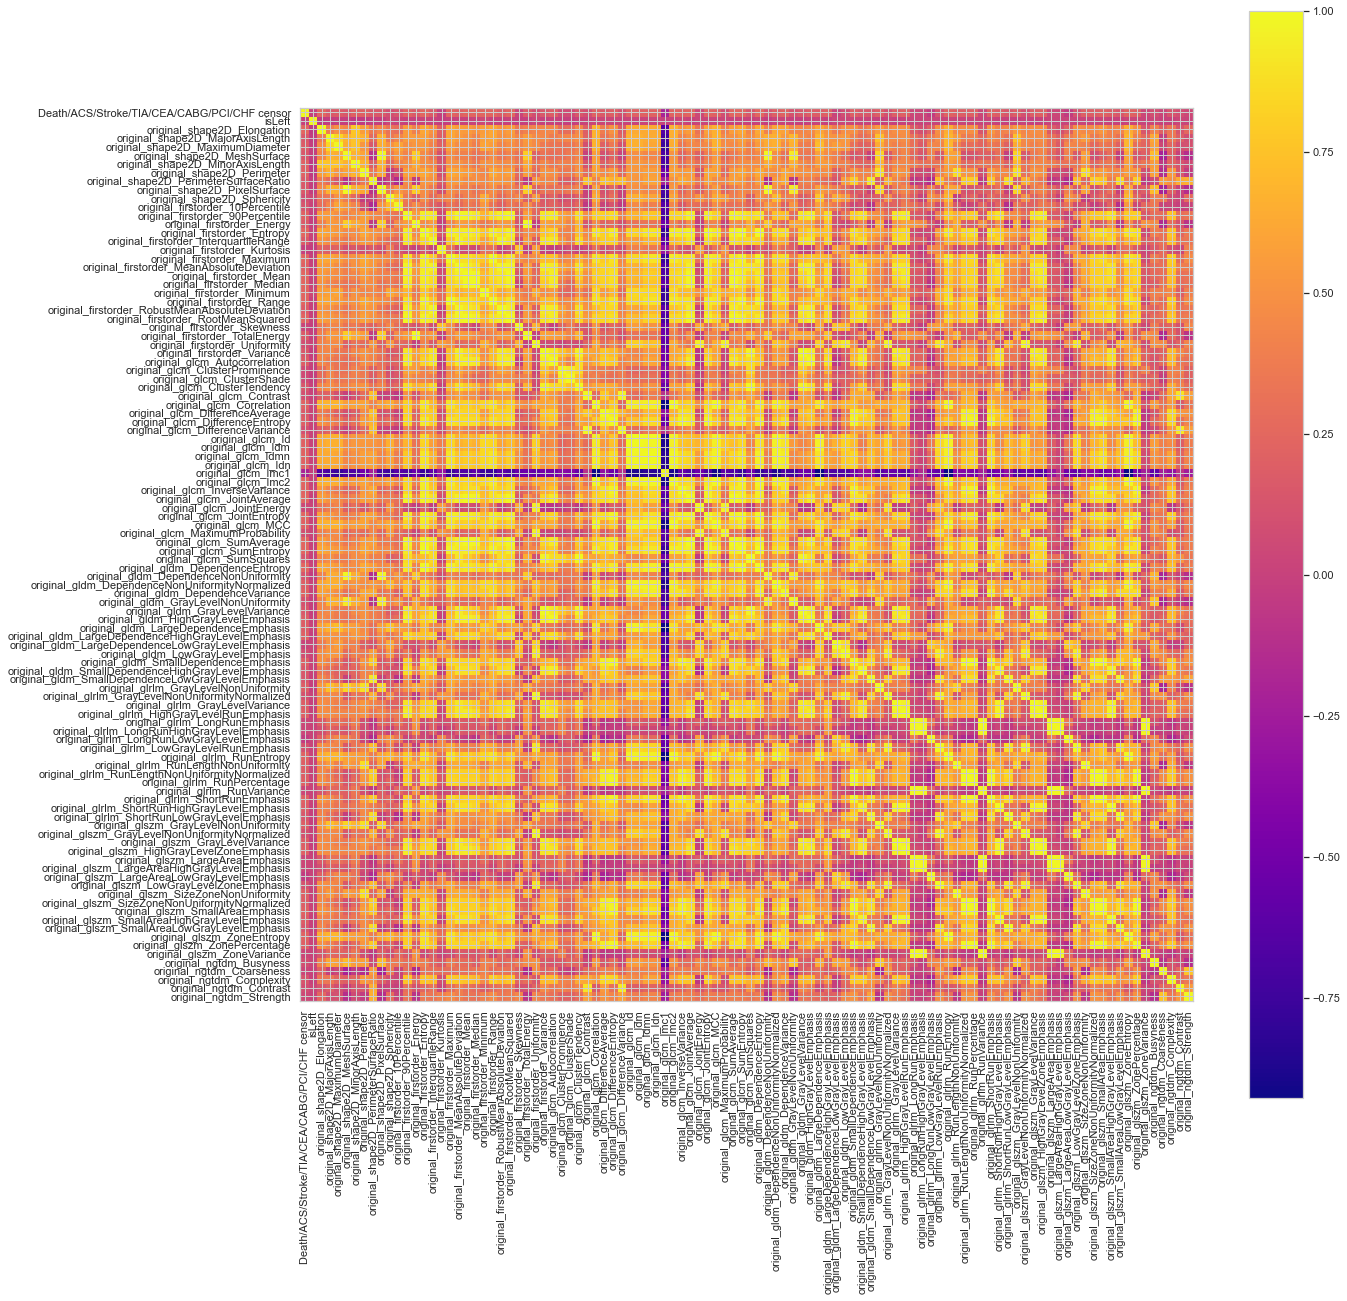

In [57]:
# repeating for radiomics
corrMatrixRadiomics = radiomicsOnly.corr()
print('Correlation Heatmap for Radiomics Data')
fig, ax = plt.subplots(figsize=[20,20])
im = ax.imshow(corrMatrixRadiomics, cmap='plasma')
ax.set_xticks(np.arange(len(corrMatrixRadiomics)))
ax.set_yticks(np.arange(len(corrMatrixRadiomics)))
ax.set_xticklabels(corrMatrixRadiomics.columns)
ax.set_yticklabels(corrMatrixRadiomics.columns)
plt.xticks(rotation='vertical')
plt.colorbar(im)
plt.savefig('corrMatrixRadiomics.png')
corrMatrixRadiomics.to_csv('corrMatrixRadiomics.csv', index = False)

In [70]:
#classifier functions

def rfTest(data, outcome, ms = 7, md = 10, sp = 10, nt = 200):
    rfc, sens, spec, acc, auc, imps = fitRF(data, k = 5, 
                                            outcome = outcome, maxDepth = md, 
                                            minSamples = ms, minSplit = sp, numTrees = nt)
    print(np.mean(sens), (1.96*np.std(sens)), np.mean(spec), (1.96*np.std(spec)),np.mean(acc), (1.96*np.std(acc)))
    
    return imps

    
def fitRF(data, k = 5, outcome = 'Death/ACS/Stroke/TIA/CEA/CABG/PCI/CHF censor', maxDepth = 5, minSamples = 5, minSplit = 5, numTrees = 20):
    
    y = data[outcome].astype(int)
    X = data.drop(columns = [outcome])
    
    kf=StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
    
    sens = []
    spec = []
    acc = []
    # have to name auc aucVal beacuse auc is the library name
    aucVal = []
    imps = []
    i = 1
    tprs = []
    aucs = []
    fig, ax = plt.subplots(figsize=(6,3.75))
    mean_fpr = np.linspace(0, 1, 100)
    
    #fitting RF on CV 
    
    for trainIdx, testIdx in kf.split(X,y):

        XTrain, XTest = X.iloc[trainIdx], X.iloc[testIdx]
        yTrain, yTest=y.iloc[trainIdx], y.iloc[testIdx]

        #building model
        rfc = RandomForestClassifier(class_weight='balanced', n_jobs = -1, warm_start = True,
                                    max_depth = maxDepth, min_samples_leaf = minSamples, min_samples_split = minSplit,
                                    n_estimators = numTrees)
        rfc.fit(XTrain,yTrain)

        # feature importances
        imps.append(rfc.feature_importances_)
        #metrics
        preds = rfc.predict(XTest)
        tn, fp, fn, tp = confusion_matrix(yTest, preds).ravel()
        sens.append(tp/(tp+fn))
        spec.append(tn/(tn+fp))
        acc.append((tp+tn)/(tp+tn+fp+fn))
        aucVal.append(roc_auc_score(yTest, rfc.predict(XTest)))
        
        viz = RocCurveDisplay.from_estimator(
        rfc,
        XTest,
        yTest,
        name="ROC fold {}".format(i),
        alpha=0.5,
        lw=1,
        ax=ax,
            
        )
        
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        i = i+1

    # plotting AUC ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
    )
    ax.legend(loc="lower right")
    plt.show()

        
    return rfc, sens, spec, acc, aucVal, imps

In [89]:
def feature_select(data,k,outcomeCol):
    #performing select k best by mutual info score
    X = data.drop(columns = outcomeCol)
    y = data[outcomeCol]
    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X, y)
    cols = selector.get_support(indices=True)
    dataFinal = X.iloc[:,cols]
    dataFinal[outcomeCol] = y
    
    return dataFinal

In [105]:
# feature selection
numRows = len(relevantColsOnly.index)
numFeatures = math.floor(numRows/30)

#creating a list of datasets to iterate through
dfList = [relevantColsOnly, clinHistAndDrugs, imagingOnly]
dfListLabels = ('Clinical History and Drugs', 'Imaging')

allFiltered = feature_select(relevantColsOnly,numFeatures,outcomeColName)
clinOnlyFiltered = feature_select(clinHistAndDrugs,numFeatures,outcomeColName)
imagingOnlyFiltered = feature_select(imagingOnly,numFeatures,outcomeColName)

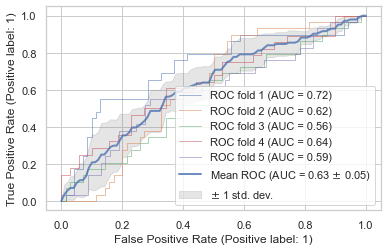

0.382512315270936 0.20056049878826435 0.7738302277432713 0.18627467853203727 0.6592661306947021 0.12642309963941115


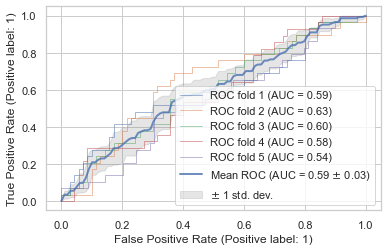

0.34679802955665023 0.18857023847754134 0.7535817805383023 0.09759918876052646 0.6348381776953206 0.045011878172485


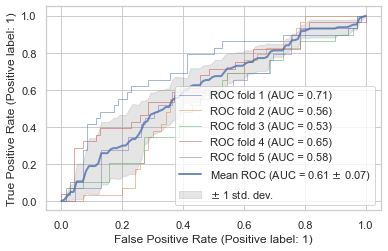

0.36182266009852226 0.19065237522972858 0.7652587991718427 0.126154585094933 0.6471243042671614 0.11218752066008933


In [106]:
allResults = rfTest(allFiltered,outcomeColName)
clinOnlyResults = rfTest(clinOnlyFiltered,outcomeColName)
imagingOnlyResults = rfTest(imagingOnlyFiltered,outcomeColName)

In [115]:
dataTemp = imagingOnlyFiltered
dataTemp = dataTemp.drop(columns=[outcomeColName])
featNames = dataTemp.columns.values.tolist()
featureImps = pd.DataFrame(data=imagingOnlyResults, index=None, columns=featNames)
featureImps

,Rt CCA Distal far wall mean IMT (mm),Lt CCA Distal far wall mean IMT (mm),"Mean CIMT, CCA far distal (mm)",Rt Max Plaque Height (mm),Lt Max Plaque Height (mm),"Max Plaque Height (PH), Rt or Lt Bulbs (mm)",Max PH ≥1.5 mm,Rt Area (mm2),Lt Area (mm2),RT % blood (0-4),RT % undefined,LT % undefined,LT p40,adjusted mean % undefined,adjusted mean p40,Mean Pixels <P40 (Rt & Lt)
0,0.056223,0.054766,0.066106,0.064756,0.063558,0.068161,0.001435,0.071654,0.069163,0.044025,0.069477,0.067255,0.074793,0.086149,0.070894,0.071586
1,0.057354,0.068987,0.090464,0.044268,0.058820,0.064479,0.001922,0.069810,0.083464,0.042591,0.061203,0.059600,0.087801,0.077505,0.072492,0.059240
2,0.054427,0.067115,0.095167,0.054214,0.054984,0.068258,0.001758,0.061015,0.083686,0.057886,0.074367,0.069561,0.064748,0.066409,0.064348,0.062058
3,0.057574,0.068512,0.088157,0.055634,0.057843,0.053054,0.002820,0.076719,0.091965,0.053107,0.065178,0.066789,0.066766,0.071146,0.060700,0.064036
4,0.054316,0.074973,0.083326,0.061427,0.067412,0.064162,0.001571,0.078895,0.047042,0.051632,0.073746,0.057750,0.077918,0.063896,0.070937,0.070996
